In [29]:
dataset = "TransnetBW.csv"
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from preprocessing import load_data_1
from models import TCNQuantileReg
from loss_functions import quantile_loss
from torch.utils.data import TensorDataset, DataLoader
import time
import os
import pandas as pd
def pad(arr, length):
    arr = np.array(arr, dtype=np.float32)
    if len(arr) < length:
        arr = np.concatenate([arr, np.full(length - len(arr), np.nan)])
    return arr

TCN QUANTILE

device: cpu
t=200, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=210, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=220, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=230, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=240, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=250, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=260, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=270, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=280, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=290, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=300, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=310, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=320, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=330, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=340, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=350, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=360, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=370, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=380, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=390, alphat=0.151

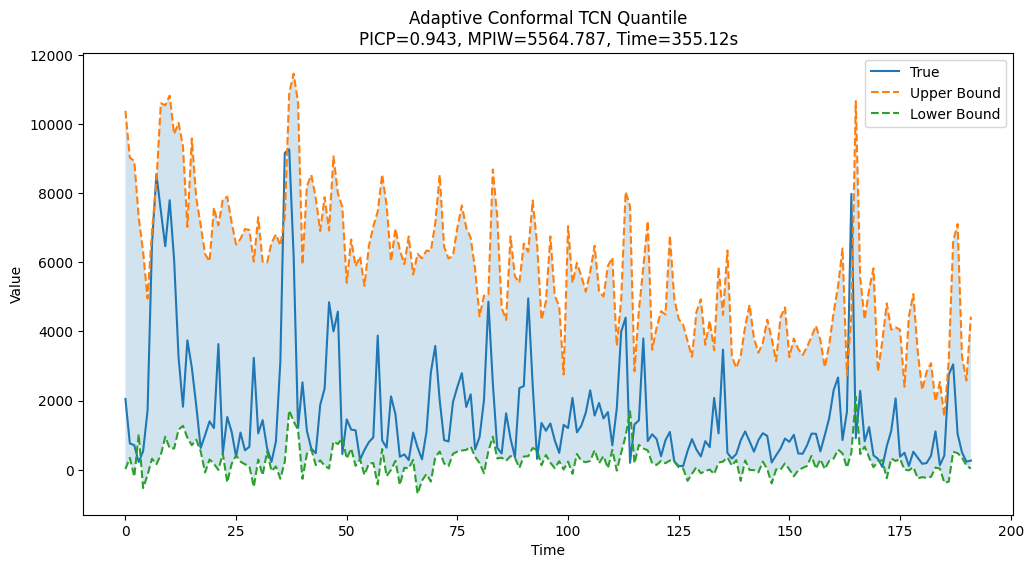

In [50]:
SEQ_LEN = 5
EPOCHS = 20
LR = 0.001
SEED = 42
BATCH_SIZE = 32
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

os.makedirs("results/aci", exist_ok=True)
full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)

def run_adaptive_conformal_tcn(alpha=0.1, gamma=0.01, tinit=200, splitSize=0.5):
    T = len(full_dataset)
    alphaTrajectory = np.zeros(T - tinit, dtype=np.float32)
    adaptErrSeq = np.zeros(T - tinit, dtype=np.float32)
    noAdaptErrorSeq = np.zeros(T - tinit, dtype=np.float32)
    y_u_preds = np.zeros(T - tinit, dtype=np.float32)
    y_l_preds = np.zeros(T - tinit, dtype=np.float32)
    y_true_vals = np.zeros(T - tinit, dtype=np.float32)
    alphat = alpha
    
    for t in range(tinit, T):
        idx = list(range(t))
        train_size = int(max(1, t * splitSize))
        if train_size >= len(idx):
            trainPoints = idx.copy()
        else:
            trainPoints = random.sample(idx, train_size)
        calPoints = [i for i in idx if i not in trainPoints]
        
        X_train = full_dataset.X[trainPoints].astype(np.float32)
        y_train = full_dataset.y[trainPoints].astype(np.float32)
        X_cal = full_dataset.X[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0, SEQ_LEN), dtype=np.float32)
        y_cal = full_dataset.y[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0,), dtype=np.float32)
        y_t = float(full_dataset.y[t])
        
        quantiles = [alphat / 2.0, 1.0 - alphat / 2.0]
        model_upper, model_lower = None, None
        
        for q in quantiles:
            model = TCNQuantileReg(input_dim=1).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)
            
            X_train_tensor = torch.tensor(X_train.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
            train_ds = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_ds, batch_size=min(BATCH_SIZE, len(train_ds)), shuffle=True)
            
            model.train()
            for epoch in range(EPOCHS):
                for X_batch, y_batch in train_loader:
                    preds = model(X_batch)
                    loss = quantile_loss(y_batch, preds, q)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            model.eval()
            if q == quantiles[0]:
                model_lower = model
            else:
                model_upper = model
                
        if len(calPoints) > 0:
            X_cal_tensor = torch.tensor(X_cal.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            with torch.no_grad():
                y_u_cal = model_upper(X_cal_tensor).cpu().numpy().reshape(-1)
                y_l_cal = model_lower(X_cal_tensor).cpu().numpy().reshape(-1)
            scores = np.maximum(y_l_cal - y_cal, y_cal - y_u_cal)
        else:
            scores = np.array([0.0], dtype=np.float32)
            
        X_t_tensor = torch.tensor(full_dataset.X[t].reshape(1, SEQ_LEN), dtype=torch.float32, device=device)
        with torch.no_grad():
            y_u_t = float(model_upper(X_t_tensor).cpu().numpy().reshape(-1)[0])
            y_l_t = float(model_lower(X_t_tensor).cpu().numpy().reshape(-1)[0])
            
        newScore = max(y_l_t - y_t, y_t - y_u_t)
        confQuantNaive = float(np.quantile(scores, 1.0 - alphat)) if scores.size > 0 else 0.0
        noAdaptError = float(newScore > confQuantNaive)
        
        if alphat >= 1.0:
            adaptErr = 1.0
        elif alphat <= 0.0:
            adaptErr = 0.0
        else:
            adaptErr = float(newScore > confQuantNaive)
            
        alphat = float(alphat + gamma * (alpha - adaptErr))
        alphat = max(0.0, min(1.0, alphat))
        
        alphaTrajectory[t - tinit] = alphat
        adaptErrSeq[t - tinit] = adaptErr
        noAdaptErrorSeq[t - tinit] = noAdaptError
        y_u_preds[t - tinit] = y_u_t
        y_l_preds[t - tinit] = y_l_t
        y_true_vals[t - tinit] = y_t
        
        if t % 10 == 0:
            print(f"t={t}, alphat={alphat:.4f}, adaptErr={adaptErr}, noAdaptErr={noAdaptError}")
            
    return alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals

start_time = time.time()
alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals = run_adaptive_conformal_tcn()
end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_true_vals_inv = scaler.inverse_transform(y_true_vals.reshape(-1,1)).flatten()

inside = (y_true_vals_inv >= y_l_preds_inv) & (y_true_vals_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_true_vals_inv, label="True")
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--")
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--")
plt.fill_between(range(len(y_true_vals_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2)
plt.legend()
title = f"Adaptive Conformal TCN Quantile\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/aci/tcn_quantile.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Plot saved as {filename}")
plt.show()

Local coverage plot saved as results/aci/local_metrics_tcn_quantile.png


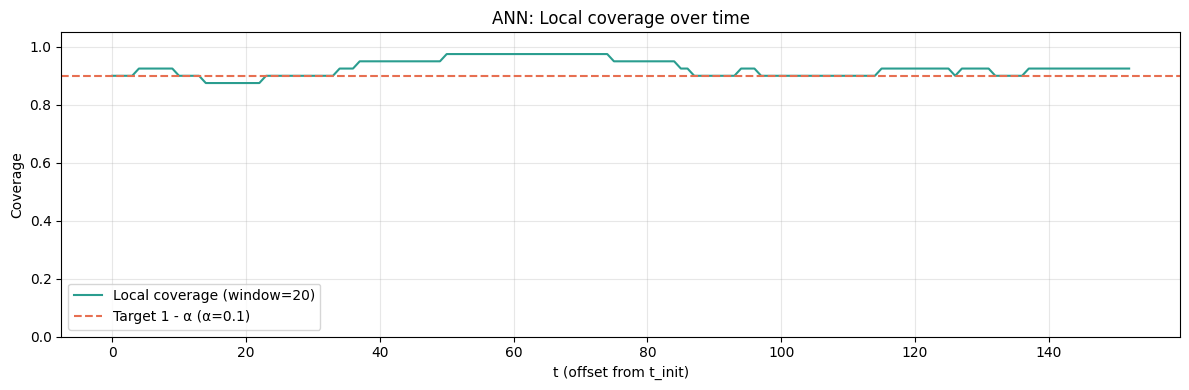

In [51]:
window = 20
alpha_nominal = 0.1
err_seq = np.asarray(adaptErrSeq, dtype=float)
N = len(err_seq)
local_cov = []
half = window
for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
    s = 0.0
    count = 0
    for i in range(start, end + 1):
        s += float(err_seq[i])
        count += 1
    local_cov.append(1.0 - (s / count))
plt.figure(figsize=(12, 4))
plt.plot(local_cov, label=f"Local coverage (window={window})", color="#2a9d8f")
plt.axhline(1.0 - alpha_nominal, color="#e76f51", linestyle="--", label=f"Target 1 - α (α={alpha_nominal})")
plt.ylim(0.0, 1.05)
plt.xlabel("t (offset from t_init)")
plt.ylabel("Coverage")
plt.title("ANN: Local coverage over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/local_metrics_tcn_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local coverage plot saved as {out_name}")
plt.show()

Local MPIW plot saved as results/aci/mpiw_ann_quantile.png


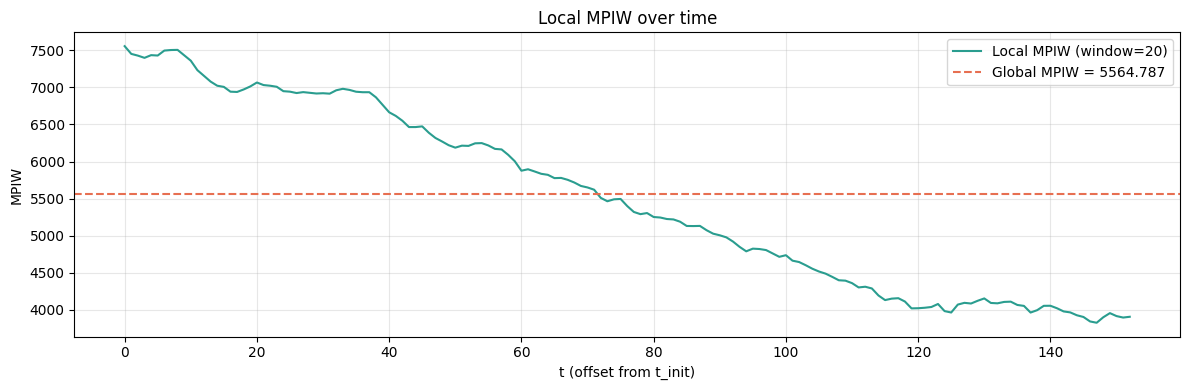

Results saved to results/aci/tcn_quantile_results.csv


In [52]:
window = 20
N = len(y_u_preds_inv)
local_mpiw = []
half = window

for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
        
    window_widths = y_u_preds_inv[start:end+1] - y_l_preds_inv[start:end+1]
    local_mpiw.append(np.mean(window_widths))

plt.figure(figsize=(12, 4))
plt.plot(local_mpiw, label=f"Local MPIW (window={window})", color="#2a9d8f")
plt.axhline(MPIW, color="#e76f51", linestyle="--", label=f"Global MPIW = {MPIW:.3f}")
plt.xlabel("t (offset from t_init)")
plt.ylabel("MPIW")
plt.title("Local MPIW over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/mpiw_ann_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local MPIW plot saved as {out_name}")
plt.show()
req_cov = 0.9
std_dev = 0
for i in range(len(local_cov)):
    std_dev += (min(local_cov[i],req_cov)-req_cov)**2
std_dev/=len(local_cov)
max_len = max(
    len(alphaTrajectory),
    len(adaptErrSeq),
    len(noAdaptErrorSeq),
    len(y_u_preds_inv),
    len(y_l_preds_inv),
    len(y_true_vals_inv),
    len(local_cov),
    len(local_mpiw)
)
results_df = pd.DataFrame({
    "alphaTrajectory": pad(alphaTrajectory, max_len),
    "adaptErrSeq": pad(adaptErrSeq, max_len),
    "noAdaptErrorSeq": pad(noAdaptErrorSeq, max_len),
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_true_vals_inv, max_len),
    "local_coverage": pad(local_cov, max_len),
    "local_mpiw": pad(local_mpiw, max_len),
    "standard_dev": [std_dev] + [np.nan] * (max_len - 1),
    "time": [time_taken] + [np.nan] * (max_len - 1),
    "picp": [PICP] + [np.nan] * (max_len - 1),
    "mpiw": [MPIW] + [np.nan] * (max_len - 1),
})
csv_filename = "results/aci/tcn_quantile_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

TCN TUBE

device: cpu
t=200, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=210, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=220, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=230, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=240, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=250, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=260, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=270, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=280, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=290, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=300, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=310, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=320, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=330, alphat=0.1610, adaptErr=0.0, noAdaptErr=0.0
t=340, alphat=0.1610, adaptErr=0.0, noAdaptErr=0.0
t=350, alphat=0.1710, adaptErr=0.0, noAdaptErr=0.0
t=360, alphat=0.1810, adaptErr=0.0, noAdaptErr=0.0
t=370, alphat=0.1710, adaptErr=0.0, noAdaptErr=0.0
t=380, alphat=0.1710, adaptErr=0.0, noAdaptErr=0.0
t=390, alphat=0.171

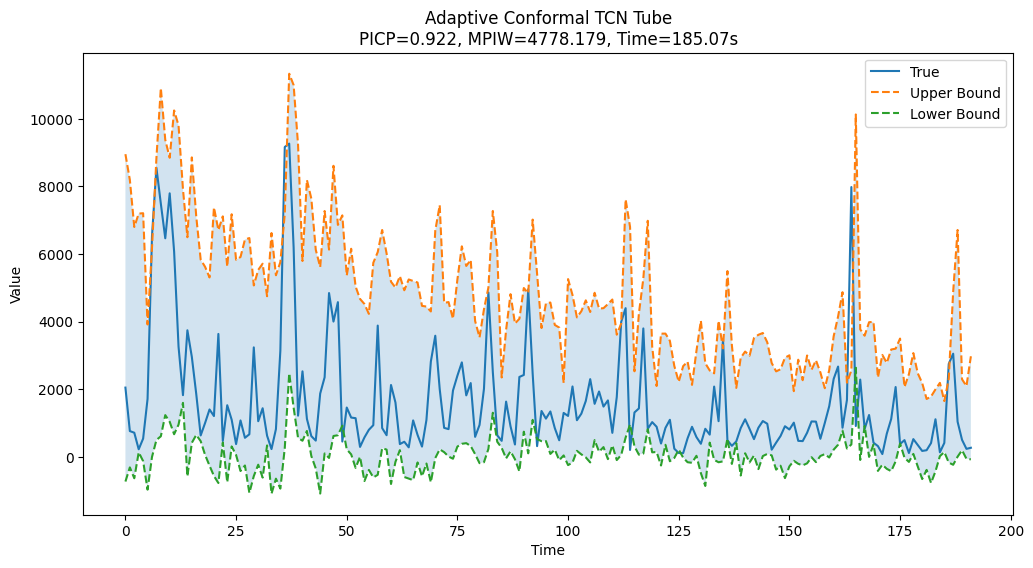

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from preprocessing import load_data_1
from models import TCNTubeReg
from loss_functions import tube_loss
from torch.utils.data import TensorDataset, DataLoader
import time

SEQ_LEN = 5
EPOCHS = 20
LR = 0.001
SEED = 42
BATCH_SIZE = 32
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = "cpu"
print("device:", device)

full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)

def run_adaptive_conformal_tcn_tube(alpha=0.1, gamma=0.01, tinit=200, splitSize=0.5):
    T = len(full_dataset)
    alphaTrajectory = np.zeros(T - tinit, dtype=np.float32)
    adaptErrSeq = np.zeros(T - tinit, dtype=np.float32)
    noAdaptErrorSeq = np.zeros(T - tinit, dtype=np.float32)
    y_u_preds = np.zeros(T - tinit, dtype=np.float32)
    y_l_preds = np.zeros(T - tinit, dtype=np.float32)
    y_true_vals = np.zeros(T - tinit, dtype=np.float32)
    alphat = alpha

    for t in range(tinit, T):
        idx = list(range(t))
        train_size = int(max(1, t * splitSize))
        if train_size >= len(idx):
            trainPoints = idx.copy()
        else:
            trainPoints = random.sample(idx, train_size)
        calPoints = [i for i in idx if i not in trainPoints]

        X_train = full_dataset.X[trainPoints].astype(np.float32)
        y_train = full_dataset.y[trainPoints].astype(np.float32)
        X_cal = full_dataset.X[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0, SEQ_LEN), dtype=np.float32)
        y_cal = full_dataset.y[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0,), dtype=np.float32)
        y_t = float(full_dataset.y[t])

        model = TCNTubeReg(input_dim=1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        X_train_tensor = torch.tensor(X_train.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
        train_ds = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_ds, batch_size=min(BATCH_SIZE, len(train_ds)), shuffle=True)

        model.train()
        for epoch in range(EPOCHS):
            for X_batch, y_batch in train_loader:
                preds = model(X_batch)
                loss = tube_loss(y_batch, preds, q=1-alphat, r=0.5, delta=0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()

        if len(calPoints) > 0:
            X_cal_tensor = torch.tensor(X_cal.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            with torch.no_grad():
                preds_cal = model(X_cal_tensor).cpu().numpy()
            y_u_cal, y_l_cal = preds_cal[:, 0], preds_cal[:, 1]
            scores = np.maximum(y_l_cal - y_cal, y_cal - y_u_cal)
        else:
            scores = np.array([0.0], dtype=np.float32)

        X_t_tensor = torch.tensor(full_dataset.X[t].reshape(1, SEQ_LEN), dtype=torch.float32, device=device)
        with torch.no_grad():
            preds_t = model(X_t_tensor).cpu().numpy()[0]
            y_u_t, y_l_t = preds_t[0], preds_t[1]

        newScore = max(y_l_t - y_t, y_t - y_u_t)
        confQuantNaive = float(np.quantile(scores, 1.0 - alphat)) if scores.size > 0 else 0.0
        noAdaptError = float(newScore > confQuantNaive)
        if alphat >= 1.0:
            adaptErr = 1.0
        elif alphat <= 0.0:
            adaptErr = 0.0
        else:
            adaptErr = float(newScore > confQuantNaive)
        alphat = float(alphat + gamma * (alpha - adaptErr))
        alphat = max(0.0, min(1.0, alphat))

        alphaTrajectory[t - tinit] = alphat
        adaptErrSeq[t - tinit] = adaptErr
        noAdaptErrorSeq[t - tinit] = noAdaptError
        y_u_preds[t - tinit] = y_u_t
        y_l_preds[t - tinit] = y_l_t
        y_true_vals[t - tinit] = y_t

        if t % 10 == 0:
            print(f"t={t}, alphat={alphat:.4f}, adaptErr={adaptErr}, noAdaptErr={noAdaptError}")

    return alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals

start_time = time.time()
alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals = run_adaptive_conformal_tcn_tube()
end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_true_vals_inv = scaler.inverse_transform(y_true_vals.reshape(-1,1)).flatten()

inside = (y_true_vals_inv >= y_l_preds_inv) & (y_true_vals_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_true_vals_inv, label="True")
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--")
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--")
plt.fill_between(range(len(y_true_vals_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2)
plt.legend()
title = f"Adaptive Conformal TCN Tube\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/aci/tcn_tube.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Plot saved as {filename}")
plt.show()

Local coverage plot saved as results/aci/local_metrics_tcn_tube.png


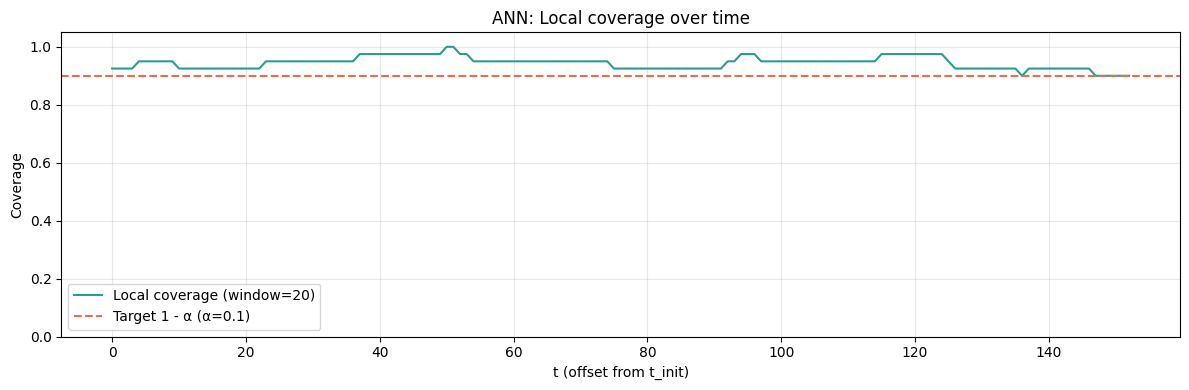

In [54]:
window = 20
alpha_nominal = 0.1
err_seq = np.asarray(adaptErrSeq, dtype=float)
N = len(err_seq)
local_cov = []
half = window
for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
    s = 0.0
    count = 0
    for i in range(start, end + 1):
        s += float(err_seq[i])
        count += 1
    local_cov.append(1.0 - (s / count))
plt.figure(figsize=(12, 4))
plt.plot(local_cov, label=f"Local coverage (window={window})", color="#2a9d8f")
plt.axhline(1.0 - alpha_nominal, color="#e76f51", linestyle="--", label=f"Target 1 - α (α={alpha_nominal})")
plt.ylim(0.0, 1.05)
plt.xlabel("t (offset from t_init)")
plt.ylabel("Coverage")
plt.title("ANN: Local coverage over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/local_metrics_tcn_tube.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local coverage plot saved as {out_name}")
plt.show()

Local MPIW plot saved as results/aci/mpiw_ann_quantile.png


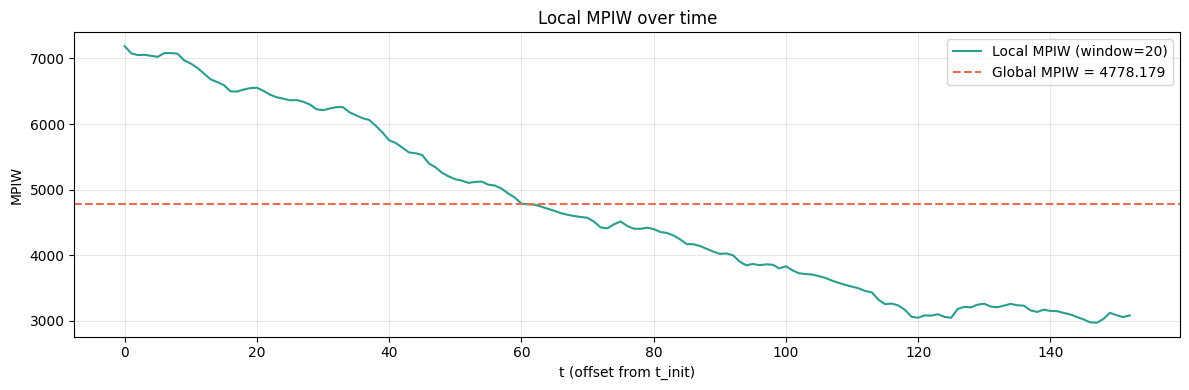

Results saved to results/aci/tcn_tube_results.csv


In [55]:
window = 20
N = len(y_u_preds_inv)
local_mpiw = []
half = window

for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
        
    window_widths = y_u_preds_inv[start:end+1] - y_l_preds_inv[start:end+1]
    local_mpiw.append(np.mean(window_widths))

plt.figure(figsize=(12, 4))
plt.plot(local_mpiw, label=f"Local MPIW (window={window})", color="#2a9d8f")
plt.axhline(MPIW, color="#e76f51", linestyle="--", label=f"Global MPIW = {MPIW:.3f}")
plt.xlabel("t (offset from t_init)")
plt.ylabel("MPIW")
plt.title("Local MPIW over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/mpiw_ann_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local MPIW plot saved as {out_name}")
plt.show()
req_cov = 0.9
std_dev = 0
for i in range(len(local_cov)):
    std_dev += (min(local_cov[i],req_cov)-req_cov)**2
std_dev/=len(local_cov)
max_len = max(
    len(alphaTrajectory),
    len(adaptErrSeq),
    len(noAdaptErrorSeq),
    len(y_u_preds_inv),
    len(y_l_preds_inv),
    len(y_true_vals_inv),
    len(local_cov),
    len(local_mpiw)
)
results_df = pd.DataFrame({
    "alphaTrajectory": pad(alphaTrajectory, max_len),
    "adaptErrSeq": pad(adaptErrSeq, max_len),
    "noAdaptErrorSeq": pad(noAdaptErrorSeq, max_len),
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_true_vals_inv, max_len),
    "local_coverage": pad(local_cov, max_len),
    "local_mpiw": pad(local_mpiw, max_len),
    "standard_dev": [std_dev] + [np.nan] * (max_len - 1),
    "time": [time_taken] + [np.nan] * (max_len - 1),
    "picp": [PICP] + [np.nan] * (max_len - 1),
    "mpiw": [MPIW] + [np.nan] * (max_len - 1),
})
csv_filename = "results/aci/tcn_tube_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

LSTM QUANTILE

device: cpu
t=200, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=210, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=220, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=230, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=240, alphat=0.0810, adaptErr=0.0, noAdaptErr=0.0
t=250, alphat=0.0810, adaptErr=0.0, noAdaptErr=0.0
t=260, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=270, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=280, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=290, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=300, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=310, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=320, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=330, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=340, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=350, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=360, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=370, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=380, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=390, alphat=0.081

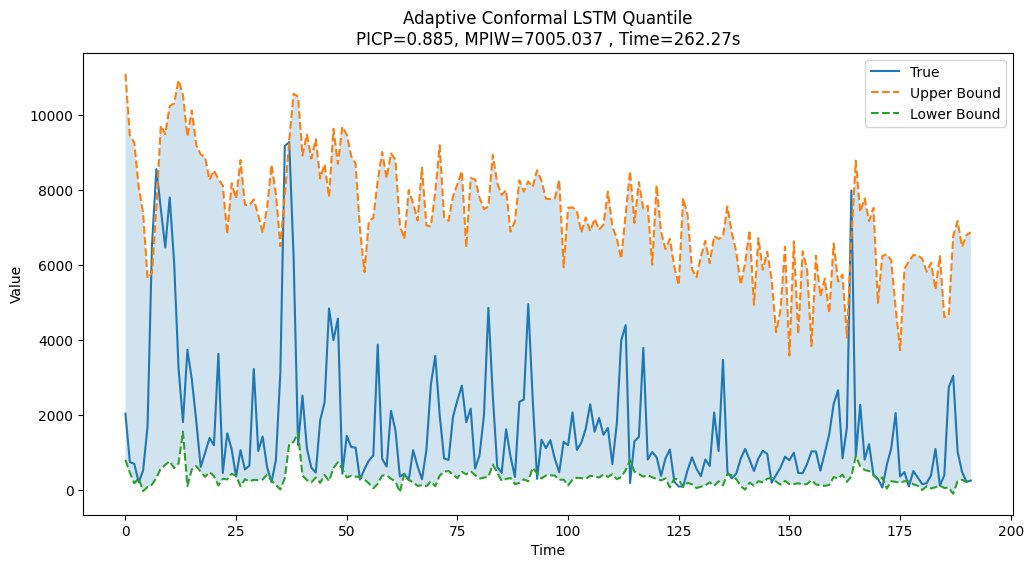

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from preprocessing import load_data_1
from models import LSTMQuantileReg
from loss_functions import quantile_loss
from torch.utils.data import TensorDataset, DataLoader
import time
SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)

def run_adaptive_conformal_lstm(alpha=0.1, gamma=0.01, tinit=200, splitSize=0.5):
    T = len(full_dataset)
    alphaTrajectory = np.zeros(T - tinit, dtype=np.float32)
    adaptErrSeq = np.zeros(T - tinit, dtype=np.float32)
    noAdaptErrorSeq = np.zeros(T - tinit, dtype=np.float32)
    y_u_preds = np.zeros(T - tinit, dtype=np.float32)
    y_l_preds = np.zeros(T - tinit, dtype=np.float32)
    y_true_vals = np.zeros(T - tinit, dtype=np.float32)
    alphat = alpha
    for t in range(tinit, T):
        idx = list(range(t))
        train_size = int(max(1, t * splitSize))
        if train_size >= len(idx):
            trainPoints = idx.copy()
        else:
            trainPoints = random.sample(idx, train_size)
        calPoints = [i for i in idx if i not in trainPoints]
        X_train = full_dataset.X[trainPoints].astype(np.float32)
        y_train = full_dataset.y[trainPoints].astype(np.float32)
        X_cal = full_dataset.X[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0, SEQ_LEN), dtype=np.float32)
        y_cal = full_dataset.y[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0,), dtype=np.float32)
        y_t = float(full_dataset.y[t])
        quantiles = [alphat / 2.0, 1.0 - alphat / 2.0]
        model_upper, model_lower = None, None
        for q in quantiles:
            model = LSTMQuantileReg().to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)
            X_train_tensor = torch.tensor(X_train.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
            train_ds = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_ds, batch_size=min(BATCH_SIZE, len(train_ds)), shuffle=True)
            model.train()
            for epoch in range(EPOCHS):
                for X_batch, y_batch in train_loader:
                    preds = model(X_batch)
                    loss = quantile_loss(y_batch, preds, q)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            model.eval()
            if q == quantiles[0]:
                model_lower = model
            else:
                model_upper = model
        if len(calPoints) > 0:
            X_cal_tensor = torch.tensor(X_cal.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            with torch.no_grad():
                y_u_cal = model_upper(X_cal_tensor).cpu().numpy().reshape(-1)
                y_l_cal = model_lower(X_cal_tensor).cpu().numpy().reshape(-1)
            scores = np.maximum(y_l_cal - y_cal, y_cal - y_u_cal)
        else:
            scores = np.array([0.0], dtype=np.float32)
        X_t_tensor = torch.tensor(full_dataset.X[t].reshape(1, SEQ_LEN), dtype=torch.float32, device=device)
        with torch.no_grad():
            y_u_t = float(model_upper(X_t_tensor).cpu().numpy().reshape(-1)[0])
            y_l_t = float(model_lower(X_t_tensor).cpu().numpy().reshape(-1)[0])
        newScore = max(y_l_t - y_t, y_t - y_u_t)
        confQuantNaive = float(np.quantile(scores, 1.0 - alphat)) if scores.size > 0 else 0.0
        noAdaptError = float(newScore > confQuantNaive)
        if alphat >= 1.0:
            adaptErr = 1.0
        elif alphat <= 0.0:
            adaptErr = 0.0
        else:
            adaptErr = float(newScore > confQuantNaive)
        alphat = float(alphat + gamma * (alpha - adaptErr))
        alphat = max(0.0, min(1.0, alphat))
        alphaTrajectory[t - tinit] = alphat
        adaptErrSeq[t - tinit] = adaptErr
        noAdaptErrorSeq[t - tinit] = noAdaptError
        y_u_preds[t - tinit] = y_u_t
        y_l_preds[t - tinit] = y_l_t
        y_true_vals[t - tinit] = y_t
        if t % 10 == 0:
            print(f"t={t}, alphat={alphat:.4f}, adaptErr={adaptErr}, noAdaptErr={noAdaptError}")
    return alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals
start_time = time.time()
alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals = run_adaptive_conformal_lstm()
end_time = time.time()
time_taken = end_time - start_time
y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_true_vals_inv = scaler.inverse_transform(y_true_vals.reshape(-1,1)).flatten()

inside = (y_true_vals_inv >= y_l_preds_inv) & (y_true_vals_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_true_vals_inv, label="True")
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--")
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--")
plt.fill_between(range(len(y_true_vals_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2)
plt.legend()
title = f"Adaptive Conformal LSTM Quantile\nPICP={PICP:.3f}, MPIW={MPIW:.3f} , Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/aci/lstm_quantile.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Plot saved as {filename}")
plt.show()

Local coverage plot saved as results/aci/local_metrics_lstm_quantile.png


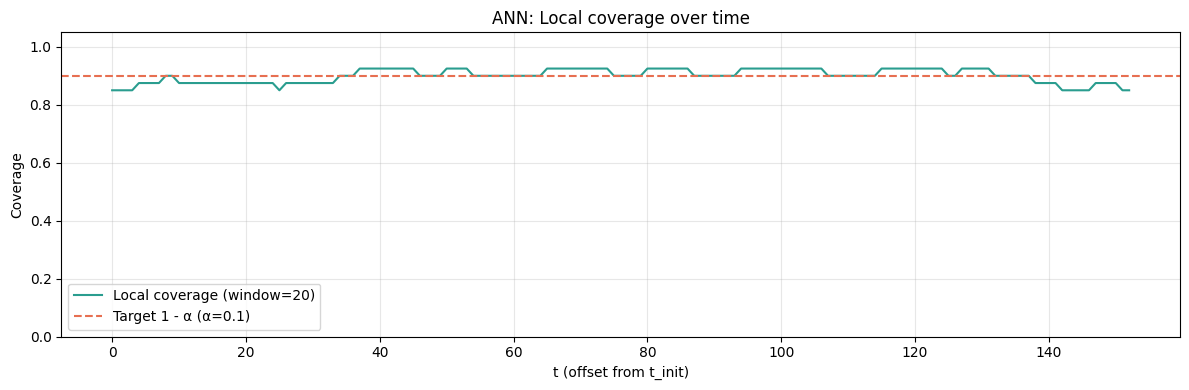

In [45]:
window = 20
alpha_nominal = 0.1
err_seq = np.asarray(adaptErrSeq, dtype=float)
N = len(err_seq)
local_cov = []
half = window
for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
    s = 0.0
    count = 0
    for i in range(start, end + 1):
        s += float(err_seq[i])
        count += 1
    local_cov.append(1.0 - (s / count))
plt.figure(figsize=(12, 4))
plt.plot(local_cov, label=f"Local coverage (window={window})", color="#2a9d8f")
plt.axhline(1.0 - alpha_nominal, color="#e76f51", linestyle="--", label=f"Target 1 - α (α={alpha_nominal})")
plt.ylim(0.0, 1.05)
plt.xlabel("t (offset from t_init)")
plt.ylabel("Coverage")
plt.title("ANN: Local coverage over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/local_metrics_lstm_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local coverage plot saved as {out_name}")
plt.show()

Local MPIW plot saved as results/aci/mpiw_ann_quantile.png


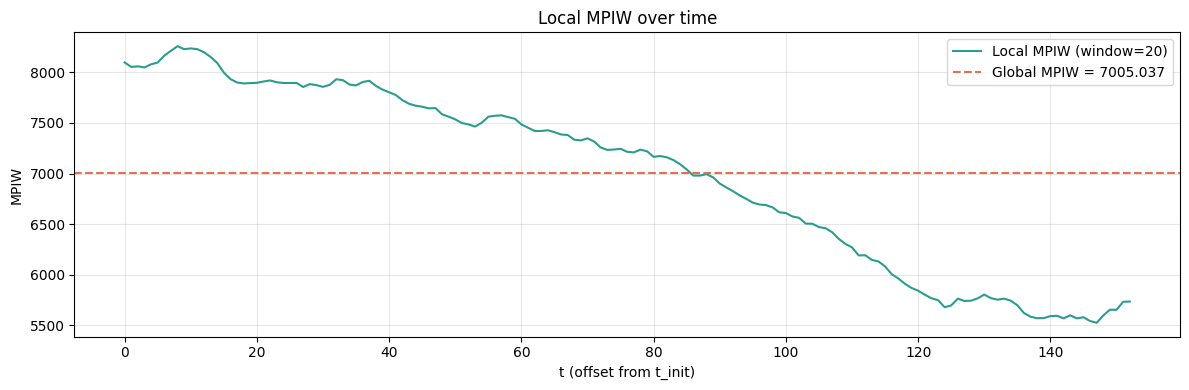

Results saved to results/aci/lstm_quantile_results.csv


In [46]:
window = 20
N = len(y_u_preds_inv)
local_mpiw = []
half = window

for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
        
    window_widths = y_u_preds_inv[start:end+1] - y_l_preds_inv[start:end+1]
    local_mpiw.append(np.mean(window_widths))

plt.figure(figsize=(12, 4))
plt.plot(local_mpiw, label=f"Local MPIW (window={window})", color="#2a9d8f")
plt.axhline(MPIW, color="#e76f51", linestyle="--", label=f"Global MPIW = {MPIW:.3f}")
plt.xlabel("t (offset from t_init)")
plt.ylabel("MPIW")
plt.title("Local MPIW over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/mpiw_ann_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local MPIW plot saved as {out_name}")
plt.show()
req_cov = 0.9
std_dev = 0
for i in range(len(local_cov)):
    std_dev += (min(local_cov[i],req_cov)-req_cov)**2
std_dev/=len(local_cov)
max_len = max(
    len(alphaTrajectory),
    len(adaptErrSeq),
    len(noAdaptErrorSeq),
    len(y_u_preds_inv),
    len(y_l_preds_inv),
    len(y_true_vals_inv),
    len(local_cov),
    len(local_mpiw)
)
results_df = pd.DataFrame({
    "alphaTrajectory": pad(alphaTrajectory, max_len),
    "adaptErrSeq": pad(adaptErrSeq, max_len),
    "noAdaptErrorSeq": pad(noAdaptErrorSeq, max_len),
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_true_vals_inv, max_len),
    "local_coverage": pad(local_cov, max_len),
    "local_mpiw": pad(local_mpiw, max_len),
    "standard_dev": [std_dev] + [np.nan] * (max_len - 1),
    "time": [time_taken] + [np.nan] * (max_len - 1),
    "picp": [PICP] + [np.nan] * (max_len - 1),
    "mpiw": [MPIW] + [np.nan] * (max_len - 1),
})
csv_filename = "results/aci/lstm_quantile_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

LSTM TUBE

device: cpu
t=200, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=210, alphat=0.0710, adaptErr=0.0, noAdaptErr=0.0
t=220, alphat=0.0810, adaptErr=0.0, noAdaptErr=0.0
t=230, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=240, alphat=0.0710, adaptErr=0.0, noAdaptErr=0.0
t=250, alphat=0.0710, adaptErr=0.0, noAdaptErr=0.0
t=260, alphat=0.0810, adaptErr=0.0, noAdaptErr=0.0
t=270, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=280, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=290, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=300, alphat=0.0910, adaptErr=0.0, noAdaptErr=0.0
t=310, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=320, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=330, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=340, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=350, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=360, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=370, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=380, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=390, alphat=0.111

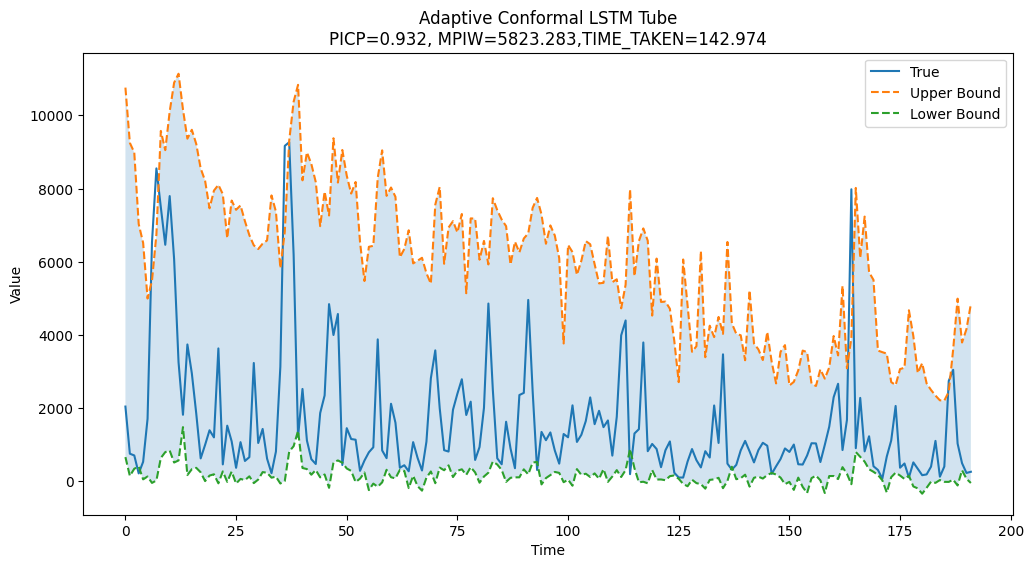

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from preprocessing import load_data_1
from models import LSTMTubeReg
from loss_functions import tube_loss
from torch.utils.data import TensorDataset, DataLoader
SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)
def run_adaptive_conformal_lstm_tube(alpha=0.1, gamma=0.01, tinit=200, splitSize=0.5):
    T = len(full_dataset)
    alphaTrajectory = np.zeros(T - tinit, dtype=np.float32)
    adaptErrSeq = np.zeros(T - tinit, dtype=np.float32)
    noAdaptErrorSeq = np.zeros(T - tinit, dtype=np.float32)
    y_u_preds = np.zeros(T - tinit, dtype=np.float32)
    y_l_preds = np.zeros(T - tinit, dtype=np.float32)
    y_true_vals = np.zeros(T - tinit, dtype=np.float32)
    alphat = alpha

    for t in range(tinit, T):
        idx = list(range(t))
        train_size = int(max(1, t * splitSize))
        if train_size >= len(idx):
            trainPoints = idx.copy()
        else:
            trainPoints = random.sample(idx, train_size)
        calPoints = [i for i in idx if i not in trainPoints]

        X_train = full_dataset.X[trainPoints].astype(np.float32)
        y_train = full_dataset.y[trainPoints].astype(np.float32)
        X_cal = full_dataset.X[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0, SEQ_LEN), dtype=np.float32)
        y_cal = full_dataset.y[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0,), dtype=np.float32)
        y_t = float(full_dataset.y[t])

        model = LSTMTubeReg().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        X_train_tensor = torch.tensor(X_train.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
        train_ds = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_ds, batch_size=min(BATCH_SIZE, len(train_ds)), shuffle=True)

        model.train()
        for epoch in range(EPOCHS):
            for X_batch, y_batch in train_loader:
                preds = model(X_batch)
                loss = tube_loss(y_batch, preds, q=1-alphat, r=0.5, delta=0.0006)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()

        if len(calPoints) > 0:
            X_cal_tensor = torch.tensor(X_cal.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            with torch.no_grad():
                preds_cal = model(X_cal_tensor).cpu().numpy()
            y_u_cal, y_l_cal = preds_cal[:, 0], preds_cal[:, 1]
            scores = np.maximum(y_l_cal - y_cal, y_cal - y_u_cal)
        else:
            scores = np.array([0.0], dtype=np.float32)

        X_t_tensor = torch.tensor(full_dataset.X[t].reshape(1, SEQ_LEN), dtype=torch.float32, device=device)
        with torch.no_grad():
            preds_t = model(X_t_tensor).cpu().numpy()[0]
            y_u_t, y_l_t = preds_t[0], preds_t[1]

        newScore = max(y_l_t - y_t, y_t - y_u_t)
        confQuantNaive = float(np.quantile(scores, 1.0 - alphat)) if scores.size > 0 else 0.0
        noAdaptError = float(newScore > confQuantNaive)
        if alphat >= 1.0:
            adaptErr = 1.0
        elif alphat <= 0.0:
            adaptErr = 0.0
        else:
            adaptErr = float(newScore > confQuantNaive)
        alphat = float(alphat + gamma * (alpha - adaptErr))
        alphat = max(0.0, min(1.0, alphat))

        alphaTrajectory[t - tinit] = alphat
        adaptErrSeq[t - tinit] = adaptErr
        noAdaptErrorSeq[t - tinit] = noAdaptError
        y_u_preds[t - tinit] = y_u_t
        y_l_preds[t - tinit] = y_l_t
        y_true_vals[t - tinit] = y_t

        if t % 10 == 0:
            print(f"t={t}, alphat={alphat:.4f}, adaptErr={adaptErr}, noAdaptErr={noAdaptError}")

    return alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals
start_time = time.time()
alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals = run_adaptive_conformal_lstm_tube()
end_time = time.time()
time_taken = end_time - start_time
y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_true_vals_inv = scaler.inverse_transform(y_true_vals.reshape(-1,1)).flatten()

inside = (y_true_vals_inv >= y_l_preds_inv) & (y_true_vals_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_true_vals_inv, label="True")
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--")
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--")
plt.fill_between(range(len(y_true_vals_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2)
plt.legend()
title = f"Adaptive Conformal LSTM Tube\nPICP={PICP:.3f}, MPIW={MPIW:.3f},TIME_TAKEN={time_taken:.3f}"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/aci/lstm_tube.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Plot saved as {filename}")
plt.show()

Local coverage plot saved as results/aci/local_metrics_lstm_tube.png


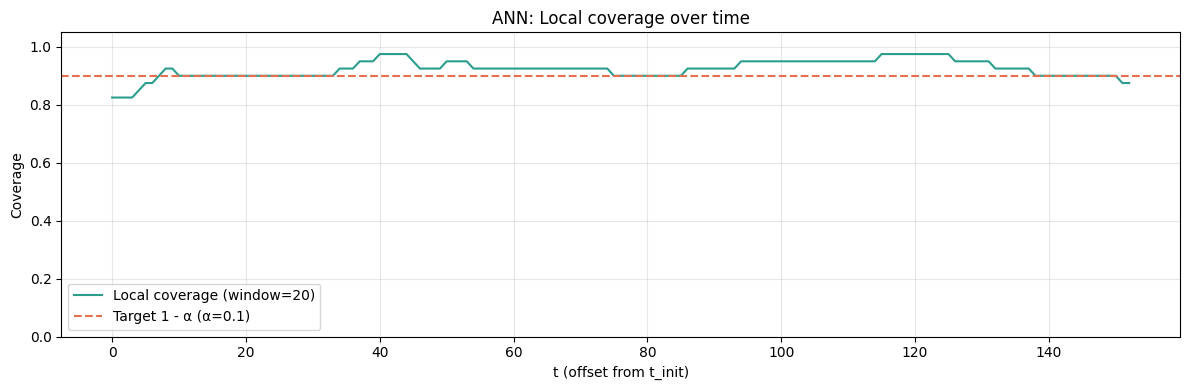

In [48]:
window = 20
alpha_nominal = 0.1
err_seq = np.asarray(adaptErrSeq, dtype=float)
N = len(err_seq)
local_cov = []
half = window
for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
    s = 0.0
    count = 0
    for i in range(start, end + 1):
        s += float(err_seq[i])
        count += 1
    local_cov.append(1.0 - (s / count))
plt.figure(figsize=(12, 4))
plt.plot(local_cov, label=f"Local coverage (window={window})", color="#2a9d8f")
plt.axhline(1.0 - alpha_nominal, color="#e76f51", linestyle="--", label=f"Target 1 - α (α={alpha_nominal})")
plt.ylim(0.0, 1.05)
plt.xlabel("t (offset from t_init)")
plt.ylabel("Coverage")
plt.title("ANN: Local coverage over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
out_name = "results/aci/local_metrics_lstm_tube.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local coverage plot saved as {out_name}")
plt.show()

Local MPIW plot saved as results/aci/mpiw_ann_quantile.png


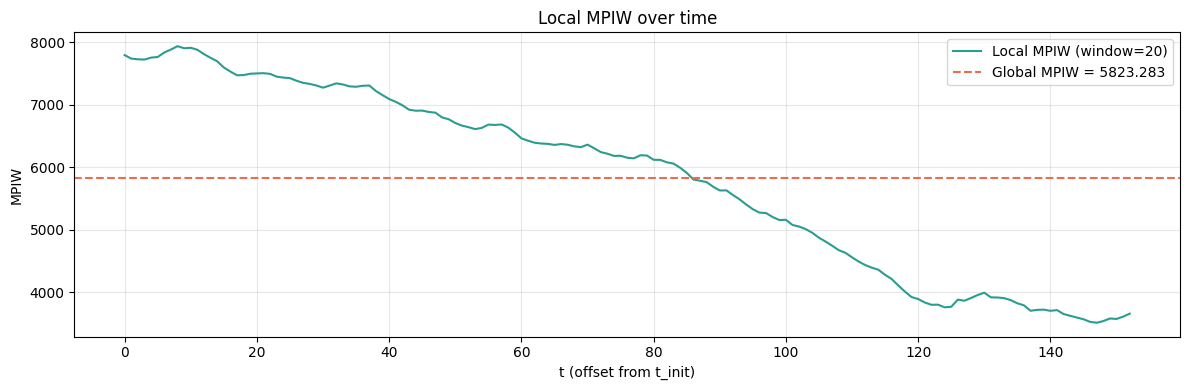

Results saved to results/aci/lstm_tube_results.csv


In [49]:
window = 20
N = len(y_u_preds_inv)
local_mpiw = []
half = window

for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
        
    window_widths = y_u_preds_inv[start:end+1] - y_l_preds_inv[start:end+1]
    local_mpiw.append(np.mean(window_widths))

plt.figure(figsize=(12, 4))
plt.plot(local_mpiw, label=f"Local MPIW (window={window})", color="#2a9d8f")
plt.axhline(MPIW, color="#e76f51", linestyle="--", label=f"Global MPIW = {MPIW:.3f}")
plt.xlabel("t (offset from t_init)")
plt.ylabel("MPIW")
plt.title("Local MPIW over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/mpiw_ann_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local MPIW plot saved as {out_name}")
plt.show()
req_cov = 0.9
std_dev = 0
for i in range(len(local_cov)):
    std_dev += (min(local_cov[i],req_cov)-req_cov)**2
std_dev/=len(local_cov)
max_len = max(
    len(alphaTrajectory),
    len(adaptErrSeq),
    len(noAdaptErrorSeq),
    len(y_u_preds_inv),
    len(y_l_preds_inv),
    len(y_true_vals_inv),
    len(local_cov),
    len(local_mpiw)
)
results_df = pd.DataFrame({
    "alphaTrajectory": pad(alphaTrajectory, max_len),
    "adaptErrSeq": pad(adaptErrSeq, max_len),
    "noAdaptErrorSeq": pad(noAdaptErrorSeq, max_len),
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_true_vals_inv, max_len),
    "local_coverage": pad(local_cov, max_len),
    "local_mpiw": pad(local_mpiw, max_len),
    "standard_dev": [std_dev] + [np.nan] * (max_len - 1),
    "time": [time_taken] + [np.nan] * (max_len - 1),
    "picp": [PICP] + [np.nan] * (max_len - 1),
    "mpiw": [MPIW] + [np.nan] * (max_len - 1),
})
csv_filename = "results/aci/lstm_tube_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

ANN TUBE

device: cpu
t=200, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=210, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=220, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=230, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=240, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=250, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=260, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=270, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=280, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=290, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=300, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=310, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=320, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=330, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=340, alphat=0.1610, adaptErr=0.0, noAdaptErr=0.0
t=350, alphat=0.1710, adaptErr=0.0, noAdaptErr=0.0
t=360, alphat=0.1810, adaptErr=0.0, noAdaptErr=0.0
t=370, alphat=0.1710, adaptErr=0.0, noAdaptErr=0.0
t=380, alphat=0.1810, adaptErr=0.0, noAdaptErr=0.0
t=390, alphat=0.171

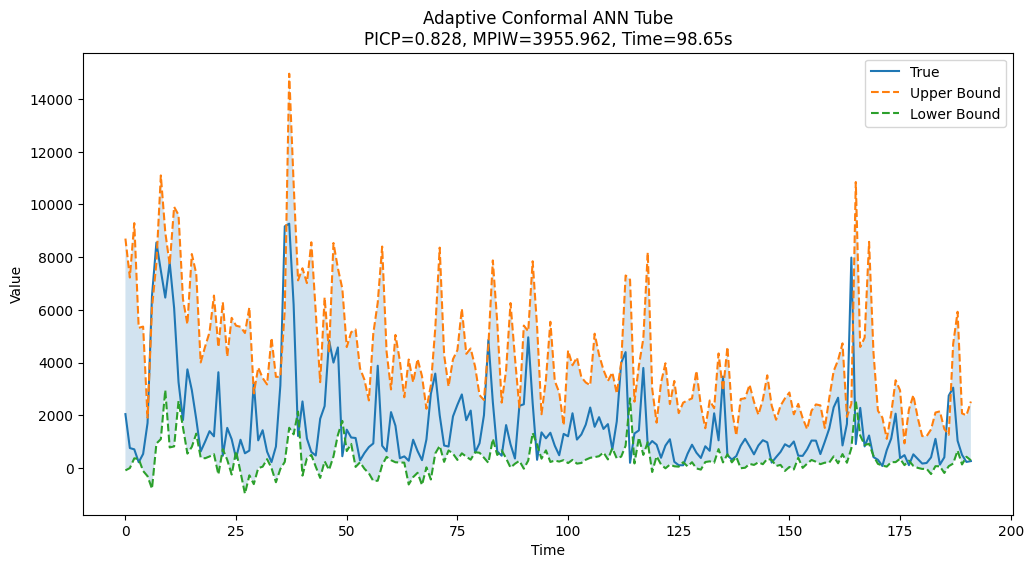

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from preprocessing import load_data_1
from models import ANNTubeReg  
from loss_functions import tube_loss
from torch.utils.data import TensorDataset, DataLoader
import time

SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)

def run_adaptive_conformal_ann_tube(alpha=0.1, gamma=0.01, tinit=200, splitSize=0.5):
    T = len(full_dataset)
    alphaTrajectory = np.zeros(T - tinit, dtype=np.float32)
    adaptErrSeq = np.zeros(T - tinit, dtype=np.float32)
    noAdaptErrorSeq = np.zeros(T - tinit, dtype=np.float32)
    y_u_preds = np.zeros(T - tinit, dtype=np.float32)
    y_l_preds = np.zeros(T - tinit, dtype=np.float32)
    y_true_vals = np.zeros(T - tinit, dtype=np.float32)
    alphat = alpha

    for t in range(tinit, T):
        idx = list(range(t))
        train_size = int(max(1, t * splitSize))
        if train_size >= len(idx):
            trainPoints = idx.copy()
        else:
            trainPoints = random.sample(idx, train_size)
        calPoints = [i for i in idx if i not in trainPoints]

        X_train = full_dataset.X[trainPoints].astype(np.float32)
        y_train = full_dataset.y[trainPoints].astype(np.float32)
        X_cal = full_dataset.X[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0, SEQ_LEN), dtype=np.float32)
        y_cal = full_dataset.y[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0,), dtype=np.float32)
        y_t = float(full_dataset.y[t])
        
        model = ANNTubeReg(input_dim=SEQ_LEN, hidden_dim=64).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        X_train_tensor = torch.tensor(X_train.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
        train_ds = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_ds, batch_size=min(BATCH_SIZE, len(train_ds)), shuffle=True)

        model.train()
        for epoch in range(EPOCHS):
            for X_batch, y_batch in train_loader:
                preds = model(X_batch) 
                loss = tube_loss(y_batch, preds, q=1-alphat, r=0.5, delta=0.0006)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()

        if len(calPoints) > 0:
            X_cal_tensor = torch.tensor(X_cal.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            with torch.no_grad():
                preds_cal = model(X_cal_tensor).cpu().numpy()
            y_u_cal, y_l_cal = preds_cal[:, 0], preds_cal[:, 1]
            scores = np.maximum(y_l_cal - y_cal, y_cal - y_u_cal)
        else:
            scores = np.array([0.0], dtype=np.float32)

        X_t_tensor = torch.tensor(full_dataset.X[t].reshape(1, SEQ_LEN), dtype=torch.float32, device=device)
        with torch.no_grad():
            preds_t = model(X_t_tensor).cpu().numpy()[0]
            y_u_t, y_l_t = preds_t[0], preds_t[1]

        newScore = max(y_l_t - y_t, y_t - y_u_t)
        confQuantNaive = float(np.quantile(scores, 1.0 - alphat)) if scores.size > 0 else 0.0
        noAdaptError = float(newScore > confQuantNaive)
        if alphat >= 1.0:
            adaptErr = 1.0
        elif alphat <= 0.0:
            adaptErr = 0.0
        else:
            adaptErr = float(newScore > confQuantNaive)
        alphat = float(alphat + gamma * (alpha - adaptErr))
        alphat = max(0.0, min(1.0, alphat))

        alphaTrajectory[t - tinit] = alphat
        adaptErrSeq[t - tinit] = adaptErr
        noAdaptErrorSeq[t - tinit] = noAdaptError
        y_u_preds[t - tinit] = y_u_t
        y_l_preds[t - tinit] = y_l_t
        y_true_vals[t - tinit] = y_t

        if t % 10 == 0:
            print(f"t={t}, alphat={alphat:.4f}, adaptErr={adaptErr}, noAdaptErr={noAdaptError}")

    return alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals


start_time = time.time()
alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals = run_adaptive_conformal_ann_tube()
end_time = time.time()
time_taken = end_time - start_time


y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_true_vals_inv = scaler.inverse_transform(y_true_vals.reshape(-1,1)).flatten()

inside = (y_true_vals_inv >= y_l_preds_inv) & (y_true_vals_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_true_vals_inv, label="True")
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--")
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--")
plt.fill_between(range(len(y_true_vals_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2)
plt.legend()
title = f"Adaptive Conformal ANN Tube\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/aci/ann_tube.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Plot saved as {filename}")
plt.show()

Local coverage plot saved as results/aci/local_metrics_ann_tube.png


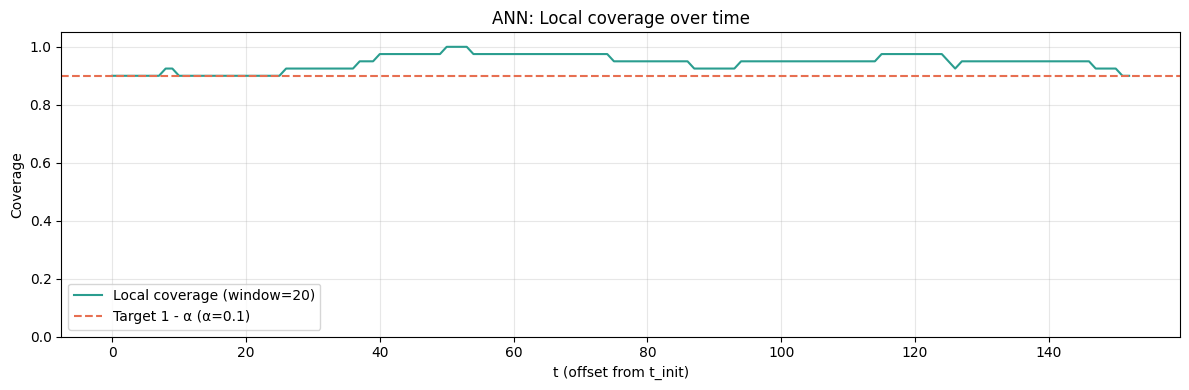

In [39]:
window = 20
alpha_nominal = 0.1
err_seq = np.asarray(adaptErrSeq, dtype=float)
N = len(err_seq)
local_cov = []
half = window
for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
    s = 0.0
    count = 0
    for i in range(start, end + 1):
        s += float(err_seq[i])
        count += 1
    local_cov.append(1.0 - (s / count))
plt.figure(figsize=(12, 4))
plt.plot(local_cov, label=f"Local coverage (window={window})", color="#2a9d8f")
plt.axhline(1.0 - alpha_nominal, color="#e76f51", linestyle="--", label=f"Target 1 - α (α={alpha_nominal})")
plt.ylim(0.0, 1.05)
plt.xlabel("t (offset from t_init)")
plt.ylabel("Coverage")
plt.title("ANN: Local coverage over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/local_metrics_ann_tube.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local coverage plot saved as {out_name}")
plt.show()

Local MPIW plot saved as results/aci/mpiw_ann_quantile.png


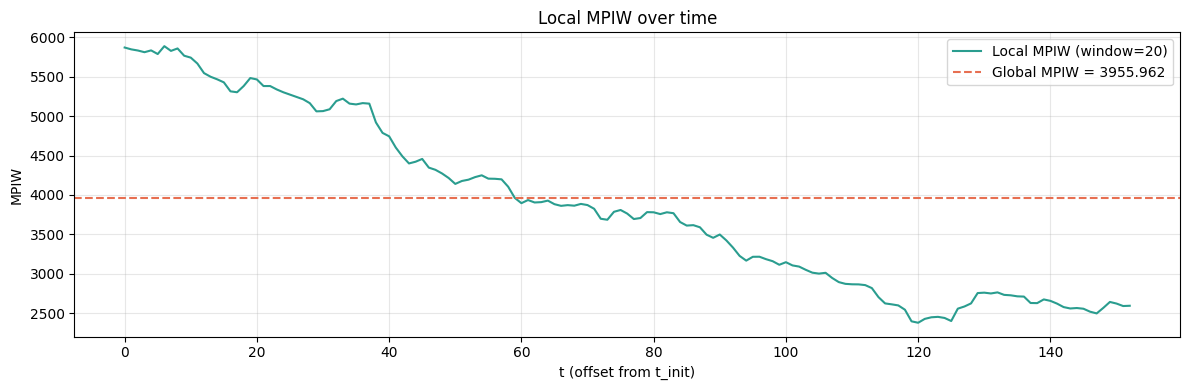

Results saved to results/aci/ann_tube_results.csv


In [40]:
window = 20
N = len(y_u_preds_inv)
local_mpiw = []
half = window

for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
        
    window_widths = y_u_preds_inv[start:end+1] - y_l_preds_inv[start:end+1]
    local_mpiw.append(np.mean(window_widths))

plt.figure(figsize=(12, 4))
plt.plot(local_mpiw, label=f"Local MPIW (window={window})", color="#2a9d8f")
plt.axhline(MPIW, color="#e76f51", linestyle="--", label=f"Global MPIW = {MPIW:.3f}")
plt.xlabel("t (offset from t_init)")
plt.ylabel("MPIW")
plt.title("Local MPIW over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/mpiw_ann_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local MPIW plot saved as {out_name}")
plt.show()
req_cov = 0.9
std_dev = 0
for i in range(len(local_cov)):
    std_dev += (min(local_cov[i],req_cov)-req_cov)**2
std_dev/=len(local_cov)
max_len = max(
    len(alphaTrajectory),
    len(adaptErrSeq),
    len(noAdaptErrorSeq),
    len(y_u_preds_inv),
    len(y_l_preds_inv),
    len(y_true_vals_inv),
    len(local_cov),
    len(local_mpiw)
)
results_df = pd.DataFrame({
    "alphaTrajectory": pad(alphaTrajectory, max_len),
    "adaptErrSeq": pad(adaptErrSeq, max_len),
    "noAdaptErrorSeq": pad(noAdaptErrorSeq, max_len),
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_true_vals_inv, max_len),
    "local_coverage": pad(local_cov, max_len),
    "local_mpiw": pad(local_mpiw, max_len),
    "standard_dev": [std_dev] + [np.nan] * (max_len - 1),
    "time": [time_taken] + [np.nan] * (max_len - 1),
    "picp": [PICP] + [np.nan] * (max_len - 1),
    "mpiw": [MPIW] + [np.nan] * (max_len - 1),
})
csv_filename = "results/aci/ann_tube_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

ANN QUANTILE

device: cpu
t=200, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=210, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=220, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=230, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=240, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=250, alphat=0.1010, adaptErr=0.0, noAdaptErr=0.0
t=260, alphat=0.1110, adaptErr=0.0, noAdaptErr=0.0
t=270, alphat=0.1210, adaptErr=0.0, noAdaptErr=0.0
t=280, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=290, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=300, alphat=0.1310, adaptErr=0.0, noAdaptErr=0.0
t=310, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=320, alphat=0.1410, adaptErr=0.0, noAdaptErr=0.0
t=330, alphat=0.1510, adaptErr=0.0, noAdaptErr=0.0
t=340, alphat=0.1610, adaptErr=0.0, noAdaptErr=0.0
t=350, alphat=0.1710, adaptErr=0.0, noAdaptErr=0.0
t=360, alphat=0.1810, adaptErr=0.0, noAdaptErr=0.0
t=370, alphat=0.1710, adaptErr=0.0, noAdaptErr=0.0
t=380, alphat=0.1810, adaptErr=0.0, noAdaptErr=0.0
t=390, alphat=0.171

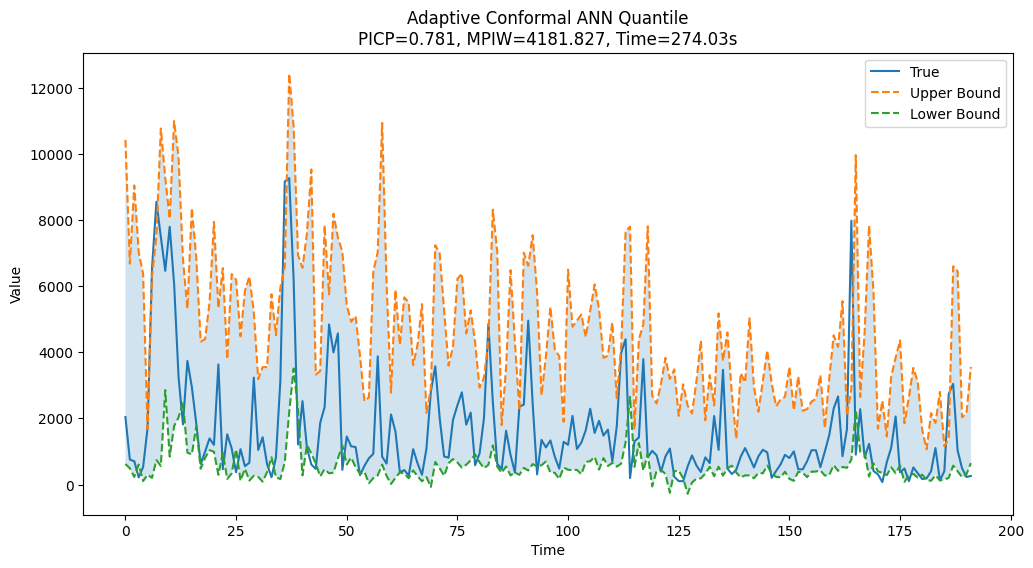

In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from preprocessing import load_data_1
from models import ANNQuantileReg 
from loss_functions import quantile_loss
from torch.utils.data import TensorDataset, DataLoader
import time
SEQ_LEN = 5
EPOCHS = 50
LR = 0.001
SEED = 42
BATCH_SIZE = 32
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
full_dataset, scaler, y, y_scaled = load_data_1(dataset, SEQ_LEN)
def run_adaptive_conformal_ann(alpha=0.1, gamma=0.01, tinit=200, splitSize=0.5):
    T = len(full_dataset)
    alphaTrajectory = np.zeros(T - tinit, dtype=np.float32)
    adaptErrSeq = np.zeros(T - tinit, dtype=np.float32)
    noAdaptErrorSeq = np.zeros(T - tinit, dtype=np.float32)
    y_u_preds = np.zeros(T - tinit, dtype=np.float32)
    y_l_preds = np.zeros(T - tinit, dtype=np.float32)
    y_true_vals = np.zeros(T - tinit, dtype=np.float32)
    alphat = alpha
    
    for t in range(tinit, T):
        idx = list(range(t))
        train_size = int(max(1, t * splitSize))
        if train_size >= len(idx):
            trainPoints = idx.copy()
        else:
            trainPoints = random.sample(idx, train_size)
        calPoints = [i for i in idx if i not in trainPoints]
        
        X_train = full_dataset.X[trainPoints].astype(np.float32)
        y_train = full_dataset.y[trainPoints].astype(np.float32)
        X_cal = full_dataset.X[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0, SEQ_LEN), dtype=np.float32)
        y_cal = full_dataset.y[calPoints].astype(np.float32) if len(calPoints) > 0 else np.empty((0,), dtype=np.float32)
        y_t = float(full_dataset.y[t])
        
        quantiles = [alphat / 2.0, 1.0 - alphat / 2.0]
        model_upper, model_lower = None, None
        
        for q in quantiles:
            model = ANNQuantileReg(input_dim=SEQ_LEN, hidden_dim=64).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)
            
            X_train_tensor = torch.tensor(X_train.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
            train_ds = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_ds, batch_size=min(BATCH_SIZE, len(train_ds)), shuffle=True)
            
            model.train()
            for epoch in range(EPOCHS):
                for X_batch, y_batch in train_loader:
                    preds = model(X_batch)
                    loss = quantile_loss(y_batch, preds, q)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            model.eval()
            if q == quantiles[0]:
                model_lower = model
            else:
                model_upper = model
                
        if len(calPoints) > 0:
            X_cal_tensor = torch.tensor(X_cal.reshape(-1, SEQ_LEN), dtype=torch.float32, device=device)
            with torch.no_grad():
                y_u_cal = model_upper(X_cal_tensor).cpu().numpy().reshape(-1)
                y_l_cal = model_lower(X_cal_tensor).cpu().numpy().reshape(-1)
            scores = np.maximum(y_l_cal - y_cal, y_cal - y_u_cal)
        else:
            scores = np.array([0.0], dtype=np.float32)
            
        X_t_tensor = torch.tensor(full_dataset.X[t].reshape(1, SEQ_LEN), dtype=torch.float32, device=device)
        with torch.no_grad():
            y_u_t = float(model_upper(X_t_tensor).cpu().numpy().reshape(-1)[0])
            y_l_t = float(model_lower(X_t_tensor).cpu().numpy().reshape(-1)[0])
            
        newScore = max(y_l_t - y_t, y_t - y_u_t)
        confQuantNaive = float(np.quantile(scores, 1.0 - alphat)) if scores.size > 0 else 0.0
        noAdaptError = float(newScore > confQuantNaive)
        
        if alphat >= 1.0:
            adaptErr = 1.0
        elif alphat <= 0.0:
            adaptErr = 0.0
        else:
            adaptErr = float(newScore > confQuantNaive)
            
        alphat = float(alphat + gamma * (alpha - adaptErr))
        alphat = max(0.0, min(1.0, alphat))
        
        alphaTrajectory[t - tinit] = alphat
        adaptErrSeq[t - tinit] = adaptErr
        noAdaptErrorSeq[t - tinit] = noAdaptError
        y_u_preds[t - tinit] = y_u_t
        y_l_preds[t - tinit] = y_l_t
        y_true_vals[t - tinit] = y_t
        
        if t % 10 == 0:
            print(f"t={t}, alphat={alphat:.4f}, adaptErr={adaptErr}, noAdaptErr={noAdaptError}")
            
    return alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals

start_time = time.time()
alphaTrajectory, adaptErrSeq, noAdaptErrorSeq, y_u_preds, y_l_preds, y_true_vals = run_adaptive_conformal_ann()
end_time = time.time()
time_taken = end_time - start_time

y_u_preds_inv = scaler.inverse_transform(y_u_preds.reshape(-1,1)).flatten()
y_l_preds_inv = scaler.inverse_transform(y_l_preds.reshape(-1,1)).flatten()
y_true_vals_inv = scaler.inverse_transform(y_true_vals.reshape(-1,1)).flatten()


inside = (y_true_vals_inv >= y_l_preds_inv) & (y_true_vals_inv <= y_u_preds_inv)
PICP = inside.mean()
MPIW = np.mean(y_u_preds_inv - y_l_preds_inv)

plt.figure(figsize=(12,6))
plt.plot(y_true_vals_inv, label="True")
plt.plot(y_u_preds_inv, label="Upper Bound", linestyle="--")
plt.plot(y_l_preds_inv, label="Lower Bound", linestyle="--")
plt.fill_between(range(len(y_true_vals_inv)), y_l_preds_inv, y_u_preds_inv, alpha=0.2)
plt.legend()
title = f"Adaptive Conformal ANN Quantile\nPICP={PICP:.3f}, MPIW={MPIW:.3f}, Time={time_taken:.2f}s"
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Value")
filename = "results/aci/ann_quantile.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Plot saved as {filename}")
plt.show()

Local coverage plot saved as results/aci/local_metrics_ann_quantile.png


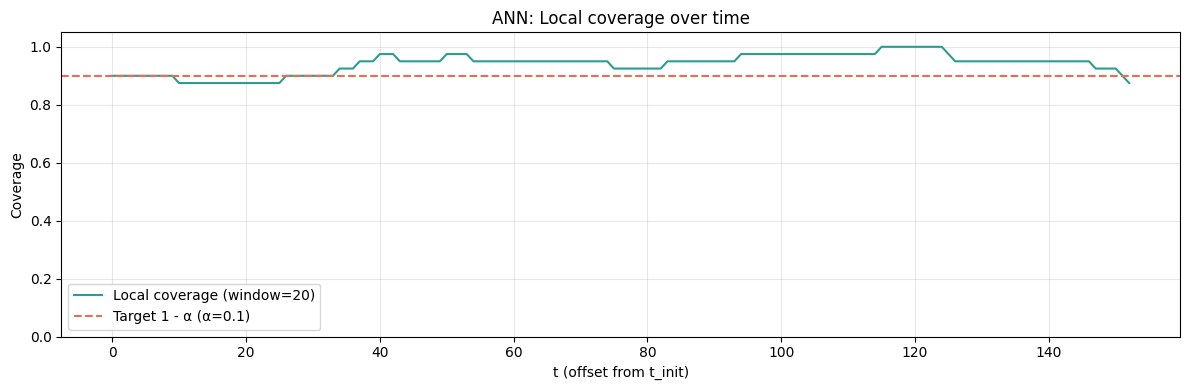

In [60]:
window = 20
alpha_nominal = 0.1
err_seq = np.asarray(adaptErrSeq, dtype=float)
N = len(err_seq)
local_cov = []
half = window
for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
    s = 0.0
    count = 0
    for i in range(start, end + 1):
        s += float(err_seq[i])
        count += 1
    local_cov.append(1.0 - (s / count))
plt.figure(figsize=(12, 4))
plt.plot(local_cov, label=f"Local coverage (window={window})", color="#2a9d8f")
plt.axhline(1.0 - alpha_nominal, color="#e76f51", linestyle="--", label=f"Target 1 - α (α={alpha_nominal})")
plt.ylim(0.0, 1.05)
plt.xlabel("t (offset from t_init)")
plt.ylabel("Coverage")
plt.title("ANN: Local coverage over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/local_metrics_ann_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local coverage plot saved as {out_name}")
plt.show()

Local MPIW plot saved as results/aci/mpiw_ann_quantile.png


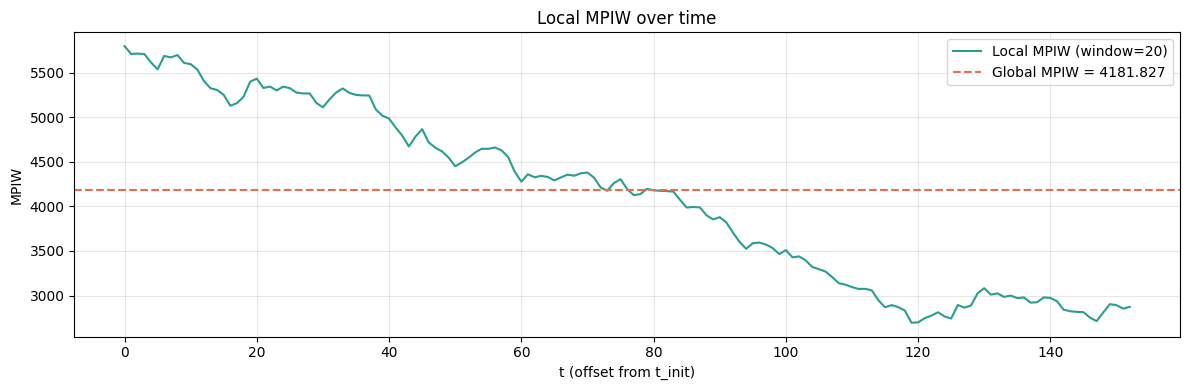

Results saved to results/aci/ann_quantile_results.csv


In [61]:
window = 20
N = len(y_u_preds_inv)
local_mpiw = []
half = window

for t in range(N):
    start = t - half + 1
    end = t + half
    if start < 0:
        continue
    if end >= N:
        continue
        
    window_widths = y_u_preds_inv[start:end+1] - y_l_preds_inv[start:end+1]
    local_mpiw.append(np.mean(window_widths))

plt.figure(figsize=(12, 4))
plt.plot(local_mpiw, label=f"Local MPIW (window={window})", color="#2a9d8f")
plt.axhline(MPIW, color="#e76f51", linestyle="--", label=f"Global MPIW = {MPIW:.3f}")
plt.xlabel("t (offset from t_init)")
plt.ylabel("MPIW")
plt.title("Local MPIW over time")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_name = "results/aci/mpiw_ann_quantile.png"
plt.savefig(out_name, dpi=300, bbox_inches="tight")
print(f"Local MPIW plot saved as {out_name}")
plt.show()
req_cov = 0.9
std_dev = 0
for i in range(len(local_cov)):
    std_dev += (min(local_cov[i],req_cov)-req_cov)**2
std_dev/=len(local_cov)
max_len = max(
    len(alphaTrajectory),
    len(adaptErrSeq),
    len(noAdaptErrorSeq),
    len(y_u_preds_inv),
    len(y_l_preds_inv),
    len(y_true_vals_inv),
    len(local_cov),
    len(local_mpiw)
)
results_df = pd.DataFrame({
    "alphaTrajectory": pad(alphaTrajectory, max_len),
    "adaptErrSeq": pad(adaptErrSeq, max_len),
    "noAdaptErrorSeq": pad(noAdaptErrorSeq, max_len),
    "y_u_preds_inv": pad(y_u_preds_inv, max_len),
    "y_l_preds_inv": pad(y_l_preds_inv, max_len),
    "y_true_vals_inv": pad(y_true_vals_inv, max_len),
    "local_coverage": pad(local_cov, max_len),
    "local_mpiw": pad(local_mpiw, max_len),
    "standard_dev": [std_dev] + [np.nan] * (max_len - 1),
    "time": [time_taken] + [np.nan] * (max_len - 1),
    "picp": [PICP] + [np.nan] * (max_len - 1),
    "mpiw": [MPIW] + [np.nan] * (max_len - 1),
})
csv_filename = "results/aci/ann_quantile_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")